In [ ]:
import os

###############
COLAB = False  # True if Google Colab
###############
#####################
INITIALIZED = False  # False if running for the first time
#####################
######################
TESTING_SAM = True  # WIP: True if testing SAM, warn!: processing time and data usage
######################
OVERRIDE = False

TESTING_UNET = True

# Other Configurations
#######################
DETAILED_LOGS = True  # True for detailed logs
DEFAULT_COLORS = False  # True for not overriding your colors
RESET_FASTSAM = False  # True to reset FastSAM repo
RESET_DATASET = False  # True to reset box_train dataset
RESET_WEIGHTS = False  # True to reset weights
#######################


os.system("pip install yachalk")

from yachalk import chalk as c  # noqa: E402

c.enable_full_colors()

by = c.bold.yellow_bright if DEFAULT_COLORS else c.bold.hex("#f0deb2")
br = c.bold.red_bright if DEFAULT_COLORS else c.bold.hex("#df8ca4")
bg = c.bold.green_bright if DEFAULT_COLORS else c.bold.hex("#abd6a0")
bb = c.bold.blue_bright if DEFAULT_COLORS else c.bold.hex("#92b3f4")
bm = c.bold.magenta_bright if DEFAULT_COLORS else c.bold.hex("#dcb6d6")
bc = c.bold.cyan_bright if DEFAULT_COLORS else c.bold.hex("#9cdae9")
bp = c.bold.hex("#c5a7f2")


def log(*args):
    if DETAILED_LOGS:
        print(bc("log:"), *args)


ROOT = os.getcwd()
if os.getcwd() == "/content" and not COLAB:
    if not OVERRIDE:
        log(br("possible environment misconfiguration"))
        log(bb("identified /content as the root which is generally the case for colab"))
        log(by("but COLAB set to False"))
        log(bg("if you wish to override this behavior set the OVERRIDE to True"))
        raise UserWarning()

print(br("--------------------------------------------"))
print(by("Google Colab") if COLAB else bm("Local"), "Environment Configured")
print(bc("Working Directory:"), ROOT)
print(br("--------------------------------------------"))

In [ ]:
if not INITIALIZED:
    # check for requirements file and get it if not present
    if not os.path.exists("requirements.txt"):
        log(br("requirements file not found:"), bb("downloading"))
        if not os.system(
            "wget https://raw.githubusercontent.com/thuvasooriya/binpick-sam/main/requirements.txt"
        ):
            log(bg("requirements file downloaded"))
        else:
            raise RuntimeError  # likely to fail due to link failing
    if not os.system("pip install -r requirements.txt"):
        log(bg("requirements installed"))
    if TESTING_SAM:
        log(bg("opted to test SAM: installing SAM dependencies"))
        if not os.system("pip install onnx onnxruntime segment-anything"):
            log(bg("onnx, onnxruntime and segment-anything installed"))
else:
    if not os.path.exists("requirements.txt") or not OVERRIDE:
        log(br("requirements file not found but INITIALIZED set to True"))
        log(bb("if this is the expected behavior set OVERRIDE to True"))
        raise UserWarning()
    log(
        br("skipping:"),
        by("INITIALIZED set to", INITIALIZED),
        bg("dependencies already installed"),
    )

In [3]:
import cv2
import torch
import torchvision

print(f"{by('PyTorch')} v{torch.__version__}")
print(f"{by('Torchvision')} v{torchvision.__version__}")
print(f"{by('OpenCV')} v{cv2.__version__}")
CUDA = torch.cuda.is_available()
MPS = torch.backends.mps.is_available()
print(f"{bg('CUDA')} Available: {bg(CUDA) if CUDA else br(CUDA)}")
print(f"{bb('MPS')} Available: {bg(MPS) if MPS else br(MPS)}")

PyTorch v2.3.0
Torchvision v0.18.0
OpenCV v4.9.0
CUDA Available: False
MPS Available: True


In [ ]:
### downloading FastSAM, SAM weights (pretrained model checkpoints)
# TODO: provide links to references and more details on the models
import gdown

if RESET_WEIGHTS:
    if os.path.exists("weights/FastSAM-s.pt"):
        os.remove("weights/FastSAM-s.pt")
    if os.path.exists("weights/FastSAM-x.pt"):
        os.remove("weights/FastSAM-x.pt")
    if os.path.exists("weights/sam_vit_h_4b8939.pt"):
        os.remove("weights/sam_vit_h_4b8939.pt")
if not os.path.exists(f"{ROOT}/weights"):
    os.mkdir(f"{ROOT}/weights")
if not os.path.exists("weights/FastSAM-s.pt"):
    gdown.download(
        "https://drive.google.com/uc?id=10XmSj6mmpmRb8NhXbtiuO9cTTBwR_9SV",
        "weights/FastSAM-s.pt",
        quiet=False,
    )
if not os.path.exists("weights/FastSAM-x.pt"):
    gdown.download(
        "https://drive.google.com/uc?id=1m1sjY4ihXBU1fZXdQ-Xdj-mDltW-2Rqv",
        "weights/FastSAM-x.pt",
        quiet=False,
    )
print(bg("FastSAM Weights Configured"))

if TESTING_SAM:
    if not os.path.exists("weights/sam_vit_h_4b8939.pth"):
        print(br("Downloading SAM weights (this may take a while...)"))
        if not os.system(
            "wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P weights/"
        ):
            print(bg("SAM weights downloaded"))
    else:
        print(by("skipping: SAM weights already downloaded"))

if TESTING_UNET:
    if not os.path.exists("weights/unet20.pth"):
        print(br("Downloading UNet weights (this may take a while...)"))
        if not os.system(
            "wget https://huggingface.co/thuvasooriya/bprs_models/resolve/main/unet20.pth?download=true -O weights/unet20.pth"
        ):
            print(bg("UNet weights downloaded"))

In [5]:
from fastsam import FastSAM

# device = "cuda" if CUDA else "cpu"
# we do not need gpu for FastSAM
device = "cpu"

# YOLOv8x-seg
model_fastsam_x = FastSAM(f"{ROOT}/weights/FastSAM-x.pt")
log(by("FastSAM-x model loaded"))
model_fastsam_x.to(device)
model_fastsam_x.info()

# YOLOv8s-seg
model_fastsam_s = FastSAM(f"{ROOT}/weights/FastSAM-s.pt")
log(by("FastSAM-s model loaded"))
model_fastsam_s.to(device)
model_fastsam_s.info()

print(by("FastSAM models loaded into"), bb(device))

if TESTING_SAM:
    from segment_anything import sam_model_registry

    sam_device = "cuda" if CUDA else "cpu"
    model_sam = sam_model_registry["vit_h"](f"{ROOT}/weights/sam_vit_h_4b8939.pth").to(
        sam_device
    )
    print(bp("SAM ViT model loaded into"), bg(sam_device))

YOLOv8x-seg summary: 401 layers, 72234149 parameters, 0 gradients
YOLOv8s-seg summary: 261 layers, 11790483 parameters, 0 gradients


log: FastSAM-x model loaded
log: FastSAM-s model loaded
FastSAM models loaded into cpu
SAM ViT model loaded into cpu


In [6]:
DETAILED_LOGS = True
TARGET_SIZE = 320 if TESTING_SAM else 960
TARGET_WIDTH = 480
TARGET_HEIGHT = 320
# TARGET_WIDTH = TARGET_SIZE
# TARGET_HEIGHT = TARGET_SIZE
FASTSAM_X = 0
FASTSAM_S = 1
SAM = 2  # WIP
RANDOM = 3
SAVE_PATH = f"{ROOT}/annotate/plt_img_{RANDOM}.jpg"

In [15]:
import numpy as np

if TESTING_SAM:
    pass

################################
### General Utility Functions
################################


def crop_n_resize(img_path, t_width=TARGET_SIZE, t_height=TARGET_SIZE):
    """
    Crop the image to the desired aspect ratio and resize it to the target height and width using OpenCV.
    """
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    aspect_ratio = t_width / t_height
    init_ratio = w / h

    # determine whether to crop the width or height
    if init_ratio > aspect_ratio:
        # crop the width
        crop_width = int(h * aspect_ratio)
        x = (w - crop_width) // 2
        # y = 0
        cropped = img[:, x : x + crop_width]
    else:
        # crop the height
        crop_height = int(w / aspect_ratio)
        # x = 0
        y = (h - crop_height) // 2
        cropped = img[y : y + crop_height, :]

    resized = cv2.resize(cropped, (t_width, t_height))

    if DETAILED_LOGS:
        h_new, w_new = resized.shape[:2]
        log(f"{w}x{h} -> {w_new}x{h_new}")

    return resized


log(bg("crop_n_resize function loaded"))


def get_coords(image, pos=0):
    """Get the coordinates of the image from an OpenCV image object
    Will return the center coordinates by default

    Args:
        image (OpenCV image): just an image
        pos (int, optional): asking for the position we want to get the coordinates. Defaults to 0.

    Returns:
        numpy.ndarray: returns the numpy array of x and y coordinates
    """
    h, w = image.shape[:2]
    if pos == 0:
        # center
        coords = [int(w / 2), int(h / 2)]
        # log(f"{bb('Center Coords...')} -> {coords}")
    elif pos == 1:
        # topleft
        coords = [int(w / 4), int(h / 4)]
        log(f"{bb('TopLeft Coords...')} -> {coords}")
    elif pos == 2:
        # top
        coords = [int(w / 2), int(h / 4)]
        log(f"{bb('Top Coords...')} -> {coords}")
    elif pos == 3:
        # topright
        coords = [int(3 * w / 4), int(h / 4)]
        log(f"{bb('TopRight Coords...')} -> {coords}")
    elif pos == 4:
        # right
        coords = [int(3 * w / 4), int(h / 2)]
        log(f"{bb('Right Coords...')} -> {coords}")
    elif pos == 5:
        # botright
        coords = [int(3 * w / 4), int(3 * h / 4)]
        log(f"{bb('BotRight Coords...')} -> {coords}")
    elif pos == 6:
        # bot
        coords = [int(w / 2), int(3 * h / 4)]
        log(f"{bb('Bot Coords...')} -> {coords}")
    elif pos == 7:
        # botleft
        coords = [int(w / 4), int(3 * h / 4)]
        log(f"{bb('BotLeft Coords...')} -> {coords}")
    elif pos == 8:
        # left
        coords = int(w / 4), int(h / 2)
        log(f"{bb('Left Coords...')} -> {coords}")
    return np.array([coords])


log(bg("get_coords function loaded"))


def list_img_paths(directory):
    """
    Returns a list of paths for all image files in a directory
    """
    img_ext = [".jpg", ".jpeg", ".png", ".gif", ".bmp"]
    img_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in img_ext):
                img_files.append(os.path.join(root, file))
    return img_files


log(bg("list_img_paths function loaded"))

log: crop_n_resize function loaded
log: get_coords function loaded
log: list_img_paths function loaded


## unet stuff

In [8]:
from torch import nn


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv_op(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(
            in_channels, in_channels // 2, kernel_size=2, stride=2
        )
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out

In [9]:
model_unet = UNet(in_channels=3, num_classes=1).to("cpu")
model_unet.load_state_dict(
    torch.load(f"{ROOT}/weights/unet20.pth", map_location=torch.device("cpu"))
)
log(by("UNet model loaded"))

log: UNet model loaded


## load test data

In [27]:
from PIL import Image
from torchvision import transforms

# getting all image paths in the box_train dataset
TEST_DATASET_PATH = f"{ROOT}/test_data"
TEST_IMG_PATHS = list_img_paths(TEST_DATASET_PATH)
log(f"{bb(len(TEST_IMG_PATHS))} images found in the test dataset")

# cropping and resizing all images to TARGET_SIZE and appending to img_arr
test_img_arr = []
unet_test_img_arr = []
TARGET_WIDTH = 640
TARGET_HEIGHT = 640
# TARGET_WIDTH = TARGET_SIZE
# TARGET_HEIGHT = TARGET_SIZE
for i, img_pth in enumerate(TEST_IMG_PATHS):
    # test_img_arr.append(cv2.imread(img_pth))
    test_img_arr.append(crop_n_resize(img_pth, TARGET_WIDTH, TARGET_HEIGHT))
    test_img_arr[i] = cv2.cvtColor(test_img_arr[i], cv2.COLOR_BGR2RGB)
    transform = transforms.Compose(
        [transforms.Resize((TARGET_WIDTH, TARGET_HEIGHT)), transforms.ToTensor()]
    )
    img = transform(Image.open(img_pth)).float().to("cpu")
    img = img.unsqueeze(0)
    unet_test_img_arr.append(img)
# print(
#     f"{bg(len(test_img_arr))} images cropped and resized to {br(TARGET_WIDTH,'x', TARGET_HEIGHT)}"
# )


# fast_sam_x_inference_times = []
fast_sam_s_inference_times = []
sam_inference_times = []
unet_inference_times = []

log: 8 images found in the test dataset
log: 899x1599 -> 640x640
log: 899x1599 -> 640x640
log: 899x1599 -> 640x640
log: 899x1599 -> 640x640
log: 4080x2296 -> 640x640
log: 4080x2296 -> 640x640
log: 4080x2296 -> 640x640
log: 899x1599 -> 640x640


## benchmarks

In [28]:
import time

from fastsam import FastSAMPrompt
from segment_anything import SamPredictor

POINT = [[320, 320]]


def measure_inference_mask_time(model, image):
    if isinstance(model, FastSAM):
        start_time = time.time()
        result = model(image, device="cuda" if torch.cuda.is_available() else "cpu")
        prompt_process = FastSAMPrompt(image, result)
        _ = prompt_process.point_prompt(points=POINT, pointlabel=[1])
        end_time = time.time()
    else:
        start_time = time.time()
        sam_predictor = SamPredictor(model)
        sam_predictor.set_image(image)
        sam_masks, _, _ = sam_predictor.predict(
            point_coords=np.array(POINT),
            point_labels=np.array([1]),
            multimask_output=True,
        )
        end_time = time.time()
    return end_time - start_time


def measure_inference_mask_time_unet(model, image):
    start_time = time.time()
    _ = model(image)
    end_time = time.time()

    # img = img.squeeze(0).cpu().detach()
    # img = img.permute(1, 2, 0)
    return end_time - start_time

In [29]:
for image in test_img_arr:
    try:
        # Measure FastSAM times
        # time_x = measure_inference_mask_time(model_fastsam_x, image)
        # log("time_x: ", time_x)
        # fast_sam_x_inference_times.append(time_x)
        time_s = measure_inference_mask_time(model_fastsam_s, image)
        log("time_s: ", time_s)
        fast_sam_s_inference_times.append(time_s)
    except Exception as e:
        print(f"Error occurred: {e}")
        print(f"Image shape: {image.shape}")

for image in test_img_arr:
    try:
        # Measure SAM times
        time_sam = measure_inference_mask_time(model_sam, image)
        log("time_sam: ", time_sam)
        sam_inference_times.append(time_sam)
    except Exception as e:
        print(f"Error occurred: {e}")
        print(f"Image shape: {image.shape}")

for image in unet_test_img_arr:
    try:
        # Measure SAM times
        time_unet = measure_inference_mask_time_unet(model_unet, image)
        log("time_unet: ", time_unet)
        unet_inference_times.append(time_unet)
    except Exception as e:
        print(f"Error occurred: {e}")
        print(f"Image shape: {image.shape}")
        # print(f"Image dtype: {image.dtype}")


# Calculate averages
# avg_fast_sam_x_inference = sum(fast_sam_x_inference_times) / len(
#     fast_sam_x_inference_times
# )
# log("avg_x:", avg_fast_sam_x_inference)
avg_fast_sam_s_inference = sum(fast_sam_s_inference_times) / len(
    fast_sam_s_inference_times
)
log("avg_s:", avg_fast_sam_s_inference)
avg_sam_inference = sum(sam_inference_times) / len(sam_inference_times)
log("avg_sam:", avg_sam_inference)

avg_unet_inference = sum(unet_inference_times) / len(unet_inference_times)
log("avg_unet:", avg_unet_inference)


0: 640x640 28 objects, 197.7ms
Speed: 2.6ms preprocess, 197.7ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 27 objects, 145.2ms
Speed: 1.0ms preprocess, 145.2ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)



log: time_s:  0.24470114707946777
log: time_s:  0.1701068878173828


0: 640x640 25 objects, 142.2ms
Speed: 0.9ms preprocess, 142.2ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 16 objects, 165.5ms
Speed: 0.7ms preprocess, 165.5ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)



log: time_s:  0.16507792472839355
log: time_s:  0.18139004707336426


0: 640x640 54 objects, 143.2ms
Speed: 0.8ms preprocess, 143.2ms inference, 10.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 47 objects, 147.4ms
Speed: 0.9ms preprocess, 147.4ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 640)



log: time_s:  0.18622899055480957
log: time_s:  0.17922306060791016


0: 640x640 48 objects, 125.7ms
Speed: 0.8ms preprocess, 125.7ms inference, 9.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 32 objects, 126.6ms
Speed: 0.9ms preprocess, 126.6ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)


log: time_s:  0.15967583656311035
log: time_s:  0.15328192710876465
log: time_sam:  11.72300100326538
log: time_sam:  9.740068674087524
log: time_sam:  11.607269048690796
log: time_sam:  9.947150230407715
log: time_sam:  10.878749132156372
log: time_sam:  12.541562795639038
log: time_sam:  11.635443925857544
log: time_sam:  10.143328189849854
log: time_unet:  1.7663731575012207
log: time_unet:  2.336570978164673
log: time_unet:  2.000847101211548
log: time_unet:  1.611372947692871
log: time_unet:  1.7941319942474365
log: time_unet:  2.3526899814605713
log: time_unet:  1.956747055053711
log: time_unet:  1.3341147899627686
log: avg_s: 0.1799607276916504
log: avg_sam: 11.027071624994278
log: avg_unet: 1.89410600066185


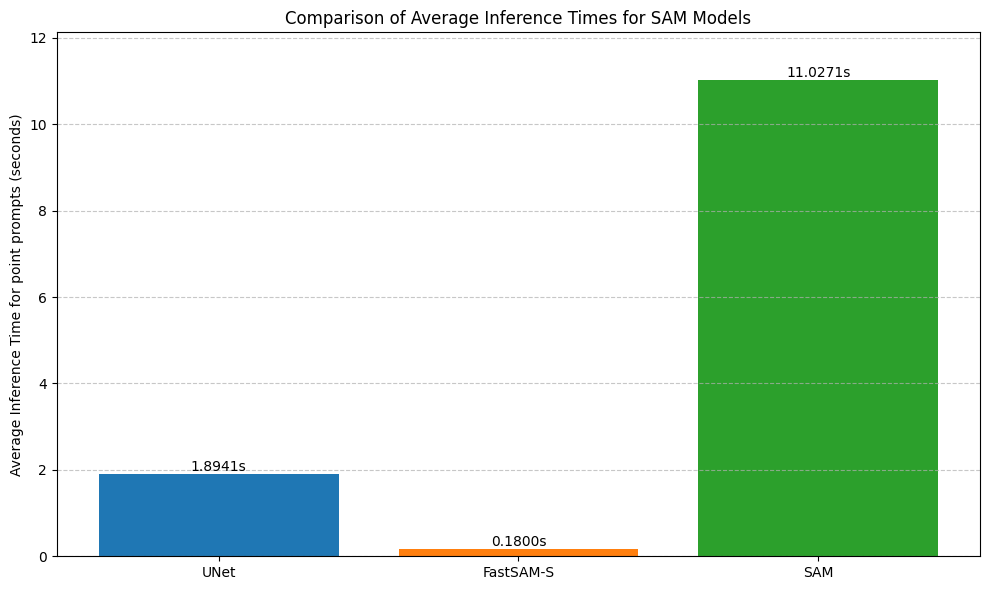

In [33]:
from matplotlib import pyplot as plt

plt.style.use("default")

models = ["UNet", "FastSAM-S", "SAM"]
avg_times = [avg_unet_inference, avg_fast_sam_s_inference, avg_sam_inference]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(models, avg_times, color=["#1f77b4", "#ff7f0e", "#2ca02c"])

ax.set_ylabel("Average Inference Time for point prompts (seconds)")
ax.set_title("Comparison of Average Inference Times for SAM Models")
ax.set_ylim(
    0, max(avg_times) * 1.1
)  # Set y-axis limit to 110% of max value for better visibility

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.4f}s",
        ha="center",
        va="bottom",
    )

# Add a grid for better readability
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()